In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [7]:
# loan_status has been removed
df_encoded = pd.get_dummies(df, columns=["home_ownership","verification_status","issue_d", "pymnt_plan","initial_list_status","next_pymnt_d","application_type","hardship_flag","debt_settlement_flag"])
df_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,0,1,1,0,1,1


In [8]:
# Redefine the column names; loan_status has been removed
columns2 = [
    "loan_amnt", "int_rate", "installment", "annual_inc","dti", "delinq_2yrs", "inq_last_6mths", 
    "open_acc", "pub_rec", "revol_bal", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", 
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_amnt","collections_12_mths_ex_med","policy_code","acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il","open_il_12m","open_il_24m","mths_since_rcnt_il","total_bal_il","il_util","open_rv_12m","open_rv_24m","max_bal_bc","all_util","total_rev_hi_lim","inq_fi","total_cu_tl","inq_last_12m","acc_open_past_24mths","avg_cur_bal","bc_open_to_buy","bc_util","chargeoff_within_12_mths","delinq_amnt","mo_sin_old_il_acct","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op","mo_sin_rcnt_tl","mort_acc","mths_since_recent_bc","mths_since_recent_inq","num_accts_ever_120_pd","num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_bc_tl","num_il_tl","num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0","num_sats","num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_op_past_12m","pct_tl_nvr_dlq","percent_bc_gt_75","pub_rec_bankruptcies","tax_liens","tot_hi_cred_lim","total_bal_ex_mort","total_bc_limit","total_il_high_credit_limit","home_ownership_ANY","home_ownership_MORTGAGE","home_ownership_OWN","home_ownership_RENT","verification_status_Not Verified","verification_status_Source Verified","verification_status_Verified","issue_d_Feb-2019","issue_d_Jan-2019","issue_d_Mar-2019","pymnt_plan_n","initial_list_status_f","initial_list_status_w","next_pymnt_d_Apr-2019","next_pymnt_d_May-2019","application_type_Individual","application_type_Joint App","hardship_flag_N","debt_settlement_flag_N"
]

In [10]:
# Create our features
# ReCreate our features based on encoded columns
X = df_encoded[columns2]

# Create our target
y = df[target]

In [11]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [12]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [17]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)
#BalancedRandomForestClassifier(random_state=1)

BalancedRandomForestClassifier(random_state=1)

In [18]:
y_pred = brf.predict(X_test)

In [19]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)
#0.7885466545953005

0.7877672625306695

In [20]:
# Display the confusion matrix
y_pred = brf.predict(X_test)
confusion_matrix(y_test, y_pred)
#array([[   71,    30],
#       [ 2153, 14951]])

array([[   58,    29],
       [ 1560, 15558]], dtype=int64)

In [21]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))
#                   pre       rec       spe        f1       geo       iba       sup

#  high_risk       0.03      0.70      0.87      0.06      0.78      0.60       101
#   low_risk       1.00      0.87      0.70      0.93      0.78      0.62     17104

#avg / total       0.99      0.87      0.70      0.93      0.78      0.62     17205

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.67      0.91      0.07      0.78      0.59        87
   low_risk       1.00      0.91      0.67      0.95      0.78      0.62     17118

avg / total       0.99      0.91      0.67      0.95      0.78      0.62     17205



In [14]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE

loan_amnt: (0.07876809003486353)
int_rate: (0.05883806887524815)
installment: (0.05625613759225244)
annual_inc: (0.05355513093134745)
dti: (0.0500331813446525)
delinq_2yrs: (0.02966959508700077)
inq_last_6mths: (0.021129125328012987)
open_acc: (0.01980242888931366)
pub_rec: (0.01747062730041245)
revol_bal: (0.016858293184471483)
total_acc: (0.01641297102011915)
out_prncp: (0.015220714904737209)
out_prncp_inv: (0.015115240704562424)
total_pymnt: (0.014926655663448373)
total_pymnt_inv: (0.014899352873994727)
total_rec_prncp: (0.014881069023035237)
total_rec_int: (0.014859446582326507)
total_rec_late_fee: (0.014832564501144122)
recoveries: (0.014613819728800227)
collection_recovery_fee: (0.014487685026878092)
last_pymnt_amnt: (0.013921085423763812)
collections_12_mths_ex_med: (0.013534131593418711)
policy_code: (0.013364759441576994)
acc_now_delinq: (0.01332289882475225)
tot_coll_amt: (0.013265926832893358)
tot_cur_bal: (0.01311545089813887)
open_acc_6m: (0.01304530062898567)
open_act_il:

In [26]:
importances = brf.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

In [27]:
importances

array([0.00982912, 0.02458052, 0.01698703, 0.01661322, 0.01862588,
       0.00452388, 0.00475626, 0.00776032, 0.00141858, 0.01492449,
       0.01048004, 0.02039888, 0.01533707, 0.05811196, 0.06073336,
       0.07376668, 0.06390324, 0.00639138, 0.        , 0.        ,
       0.04951778, 0.00069491, 0.        , 0.        , 0.00378968,
       0.01423847, 0.00600478, 0.00666004, 0.00524884, 0.0068764 ,
       0.01043385, 0.01351439, 0.013139  , 0.00541331, 0.00659981,
       0.01837888, 0.0130093 , 0.01119472, 0.00740497, 0.00794881,
       0.00970921, 0.00742067, 0.0150665 , 0.01334386, 0.01623198,
       0.        , 0.        , 0.01406737, 0.01458321, 0.01017148,
       0.00888343, 0.00639377, 0.01072809, 0.01582192, 0.00390292,
       0.00828741, 0.00781388, 0.00678543, 0.00939407, 0.00733951,
       0.00939096, 0.01192775, 0.00990082, 0.00784173, 0.        ,
       0.        , 0.00110461, 0.00606583, 0.01048577, 0.0079446 ,
       0.00152091, 0.        , 0.01310601, 0.01428231, 0.01538

In [28]:
sorted_indices

array([15, 16, 14, 13, 20,  1, 11,  4, 35, 84,  2,  3, 44, 53, 74, 12, 42,
       85,  9, 48, 73, 25, 47, 31, 43, 32, 72, 36, 75, 61, 37, 52, 68, 10,
       30, 49, 62,  0, 40, 58, 60, 50, 55, 39, 69, 63, 56,  7, 41, 38, 59,
       29, 57, 27, 34, 51, 17, 67, 26, 89, 33, 28, 83, 90,  6,  5, 54, 24,
       78, 77, 81, 82, 80, 79, 70,  8, 87, 91, 66, 88, 92, 21, 76, 65, 64,
       93, 19, 18, 86, 45, 23, 22, 71, 46, 94], dtype=int64)

In [40]:
print(brf.feature_importances_)

[0.00982912 0.02458052 0.01698703 0.01661322 0.01862588 0.00452388
 0.00475626 0.00776032 0.00141858 0.01492449 0.01048004 0.02039888
 0.01533707 0.05811196 0.06073336 0.07376668 0.06390324 0.00639138
 0.         0.         0.04951778 0.00069491 0.         0.
 0.00378968 0.01423847 0.00600478 0.00666004 0.00524884 0.0068764
 0.01043385 0.01351439 0.013139   0.00541331 0.00659981 0.01837888
 0.0130093  0.01119472 0.00740497 0.00794881 0.00970921 0.00742067
 0.0150665  0.01334386 0.01623198 0.         0.         0.01406737
 0.01458321 0.01017148 0.00888343 0.00639377 0.01072809 0.01582192
 0.00390292 0.00828741 0.00781388 0.00678543 0.00939407 0.00733951
 0.00939096 0.01192775 0.00990082 0.00784173 0.         0.
 0.00110461 0.00606583 0.01048577 0.0079446  0.00152091 0.
 0.01310601 0.01428231 0.01538569 0.01210422 0.00013273 0.00200601
 0.00208536 0.00169953 0.00185446 0.00198407 0.00187892 0.00487121
 0.01748003 0.01492646 0.         0.00138795 0.00080503 0.00592034
 0.00480282 0.001239

In [38]:
# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00983
Feature: 1, Score: 0.02458
Feature: 2, Score: 0.01699
Feature: 3, Score: 0.01661
Feature: 4, Score: 0.01863
Feature: 5, Score: 0.00452
Feature: 6, Score: 0.00476
Feature: 7, Score: 0.00776
Feature: 8, Score: 0.00142
Feature: 9, Score: 0.01492
Feature: 10, Score: 0.01048
Feature: 11, Score: 0.02040
Feature: 12, Score: 0.01534
Feature: 13, Score: 0.05811
Feature: 14, Score: 0.06073
Feature: 15, Score: 0.07377
Feature: 16, Score: 0.06390
Feature: 17, Score: 0.00639
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.04952
Feature: 21, Score: 0.00069
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00379
Feature: 25, Score: 0.01424
Feature: 26, Score: 0.00600
Feature: 27, Score: 0.00666
Feature: 28, Score: 0.00525
Feature: 29, Score: 0.00688
Feature: 30, Score: 0.01043
Feature: 31, Score: 0.01351
Feature: 32, Score: 0.01314
Feature: 33, Score: 0.00541
Feature: 34, Score: 0.00660
Feature: 35, Score: 0.01838
Fe

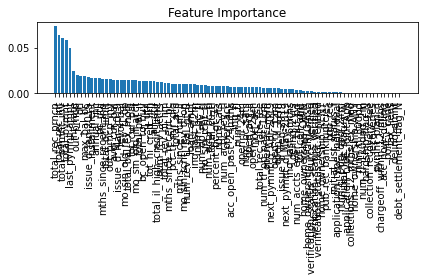

In [48]:
import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Easy Ensemble AdaBoost Classifier

In [41]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
eec = EasyEnsembleClassifier(n_estimators=100,random_state=1)
eec.fit(X_train, y_train)
#EasyEnsembleClassifier(n_estimators=100, random_state=1)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [42]:
y_pred = eec.predict(X_test)

In [43]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)
#0.9316600714093861

0.925427358175101

In [44]:
# Display the confusion matrix
print(confusion_matrix(y_test, y_pred))
#array([[   93,     8],
#       [  983, 16121]])

[[   79     8]
 [  979 16139]]


In [45]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))
#                   pre       rec       spe        f1       geo       iba       sup

#  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
#   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

#avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205

